<a href="https://colab.research.google.com/github/frankblue10/TFM_CUANTICA/blob/main/TFM_Pruebas_VQC_SVM_Clasificacion_Galaxias_Frank_Valdivia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Paso 1: Instalar dependencias necesarias
!pip install pennylane pandas scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 112.2 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade "jax[cpu]"==0.4.28 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 7.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbax-checkpoint 0.11.13 requires jax>=0.5.0, but you have jax 0.4.28 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.28 which is incompatible.


Saving galaxias_preprocesadas.csv to galaxias_preprocesadas (5).csv
Paso 0 - Costo: 0.4547
Paso 5 - Costo: 0.3732
Paso 10 - Costo: 0.2993
Paso 15 - Costo: 0.2581
Paso 19 - Costo: 0.2431

🔍 Precisión del modelo VQC con ANGLE EMBEDDING: 0.67

🧾 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.40      0.55       100
           1       0.61      0.94      0.74       100

    accuracy                           0.67       200
   macro avg       0.74      0.67      0.64       200
weighted avg       0.74      0.67      0.64       200



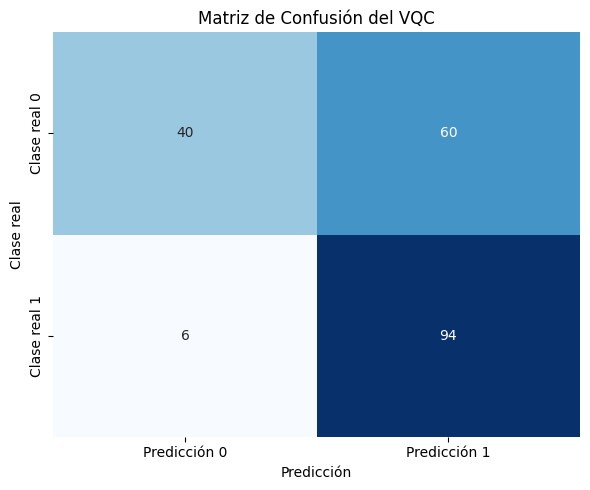

In [ ]:
#PRUEBAS
# Paso 1: Subir el archivo CSV
from google.colab import files
uploaded = files.upload()

# Paso 2: Importar librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Paso 3: Cargar y preparar datos
archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo)

# Usamos las 8 columnas seleccionadas anteriormente (sin 'concentracion')
X = df.drop(columns=["etiqueta", "concentracion"])
y = df["etiqueta"]

# Escalar las características (opcional pero recomendable)
escalador = StandardScaler()
X_escalado = escalador.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X_escalado, y, test_size=0.2, random_state=42, stratify=y
)

# Convertir etiquetas a array NumPy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Paso 4: Importación librerías
#!pip install pennylane --quiet
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer

# Crear dispositivo
num_cubits = X_train.shape[1]  # uno por variable (8)
num_capas = 3
dev = qml.device("default.cubit", wires=num_cubits)

# Paso 5: Definir circuito con AngleEmbedding
def circuito_cuantico(x, parametros):
    qml.AngleEmbedding(x, wires=range(num_cubits), rotation='Y')
    qml.StronglyEntanglingLayers(parametros, wires=range(num_cubits))
    return qml.expval(qml.PauliZ(wires=num_cubits - 1))

# QNode
@qml.qnode(dev)
def qnode(x, parametros):
    return circuito_cuantico(x, parametros)

# Paso 6: Definir clasificador cuántico
class ClasificadorCuantico:
    def __init__(self, pasos=20, tasa_aprendizaje=0.05):
        self.pasos = pasos
        self.tasa = tasa_aprendizaje
        self.parametros = pnp.random.randn(num_capas, num_cubits, 3, requires_grad=True)

    def entrenar(self, X, y):
        opt = AdamOptimizer(self.tasa)
        for paso in range(self.pasos):
            self.parametros = opt.step(lambda p: self._costo(p, X, y), self.parametros)
            if paso % 5 == 0 or paso == self.pasos - 1:
                print(f"Paso {paso} - Costo: {self._costo(self.parametros, X, y):.4f}")

    def _costo(self, parametros, X, y):
        predicciones = [qnode(x, parametros) for x in X]
        return pnp.mean((pnp.array(predicciones) - y) ** 2)

    def predecir(self, X):
        return [1 if qnode(x, self.parametros) >= 0 else 0 for x in X]

# Paso 7: Entrenamiento y evaluación
modelo = ClasificadorCuantico(pasos=20, tasa_aprendizaje=0.05)
modelo.entrenar(X_train, y_train)

y_pred = modelo.predecir(X_test)

# Evaluación
print("\n Precisión del modelo VQC con ANGLE EMBEDDING:", accuracy_score(y_test, y_pred))
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred))


#Grafica
# Paso 1: Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Crear matriz
matriz = confusion_matrix(y_test, y_pred)

# Mostrar gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicción 0", "Predicción 1"],
            yticklabels=["Clase real 0", "Clase real 1"])
plt.title("Matriz de Confusión del VQC")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.tight_layout()
plt.show()


Saving galaxias_preprocesadas.csv to galaxias_preprocesadas (4).csv
Paso 0 - Costo: 0.4974
Paso 5 - Costo: 0.4838
Paso 10 - Costo: 0.4696
Paso 15 - Costo: 0.4531
Paso 20 - Costo: 0.4341
Paso 24 - Costo: 0.4173

🔍 Precisión del modelo VQC con ANGLE EMBEDDING: 0.495

🧾 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.48      0.11      0.18       100
           1       0.50      0.88      0.64       100

    accuracy                           0.49       200
   macro avg       0.49      0.49      0.41       200
weighted avg       0.49      0.49      0.41       200



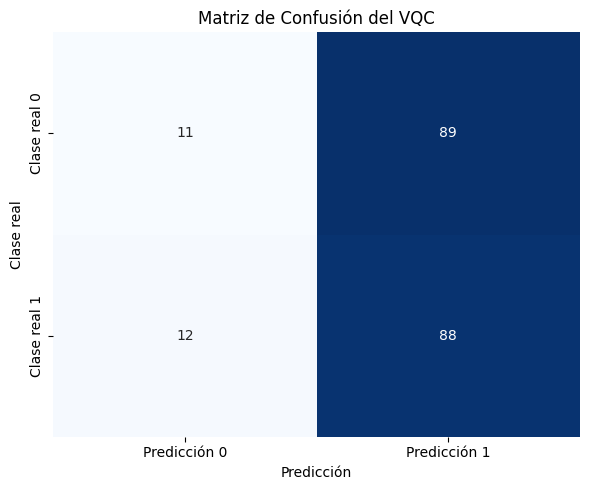

In [ ]:
#PRUEBAS
# Paso 1: Subir el archivo CSV
from google.colab import files
uploaded = files.upload()

# Paso 2: Importar librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Paso 3: Cargar y preparar datos
archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo)

# Usamos las 8 columnas seleccionadas anteriormente (sin 'concentracion')
X = df.drop(columns=["etiqueta", "concentracion"])
y = df["etiqueta"]

# Escalar las características (opcional pero recomendable)
escalador = StandardScaler()
X_escalado = escalador.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X_escalado, y, test_size=0.2, random_state=42, stratify=y
)

# Convertir etiquetas a array NumPy
y_train = np.array(y_train)
y_test = np.array(y_test)

# Paso 4: Importación librerías
!pip install pennylane --quiet
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer

# Crear dispositivo
num_cubits = X_train.shape[1]  # uno por variable (8)
num_capas = 3
dev = qml.device("default.cubit", wires=num_cubits)

# Paso 5: Definir circuito con AngleEmbedding
def circuito_cuantico(x, parametros):
    qml.AngleEmbedding(x, wires=range(num_cubits), rotation='Y')
    qml.StronglyEntanglingLayers(parametros, wires=range(num_cubits))
    return qml.expval(qml.PauliZ(wires=num_cubits - 1))

# QNode
@qml.qnode(dev)
def qnode(x, parametros):
    return circuito_cuantico(x, parametros)

# Paso 6: Definir clasificador cuántico
class ClasificadorCuantico:
    def __init__(self, pasos=25, tasa_aprendizaje=0.01):
        self.pasos = pasos
        self.tasa = tasa_aprendizaje
        self.parametros = pnp.random.randn(num_capas, num_cubits, 3, requires_grad=True)

    def entrenar(self, X, y):
        opt = AdamOptimizer(self.tasa)
        for paso in range(self.pasos):
            self.parametros = opt.step(lambda p: self._costo(p, X, y), self.parametros)
            if paso % 5 == 0 or paso == self.pasos - 1:
                print(f"Paso {paso} - Costo: {self._costo(self.parametros, X, y):.4f}")

    def _costo(self, parametros, X, y):
        predicciones = [qnode(x, parametros) for x in X]
        return pnp.mean((pnp.array(predicciones) - y) ** 2)

    def predecir(self, X):
        return [1 if qnode(x, self.parametros) >= 0 else 0 for x in X]

# Paso 7: Entrenamiento y evaluación
modelo = ClasificadorCuantico(pasos=25, tasa_aprendizaje=0.01)
modelo.entrenar(X_train, y_train)

y_pred = modelo.predecir(X_test)

# Evaluación
print("\n Precisión del modelo VQC con ANGLE EMBEDDING:", accuracy_score(y_test, y_pred))
print("\n Reporte de clasificación:")
print(classification_report(y_test, y_pred))


#Grafica
# Matriz de confusión
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Crear matriz
matriz = confusion_matrix(y_test, y_pred)

# Mostrar gráfica
plt.figure(figsize=(6, 5))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["Predicción 0", "Predicción 1"],
            yticklabels=["Clase real 0", "Clase real 1"])
plt.title("Matriz de Confusión del VQC")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.tight_layout()
plt.show()

Saving galaxias_preprocesadas.csv to galaxias_preprocesadas (6).csv
Paso 0 - Costo: 0.4891
Paso 5 - Costo: 0.4290
Paso 10 - Costo: 0.3778
Paso 15 - Costo: 0.3244
Paso 19 - Costo: 0.2849


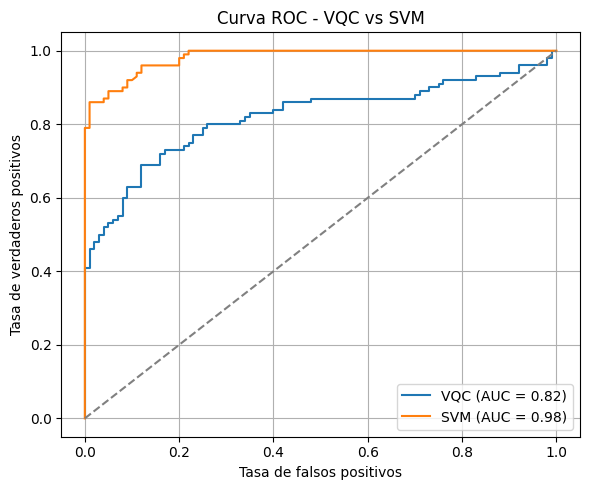

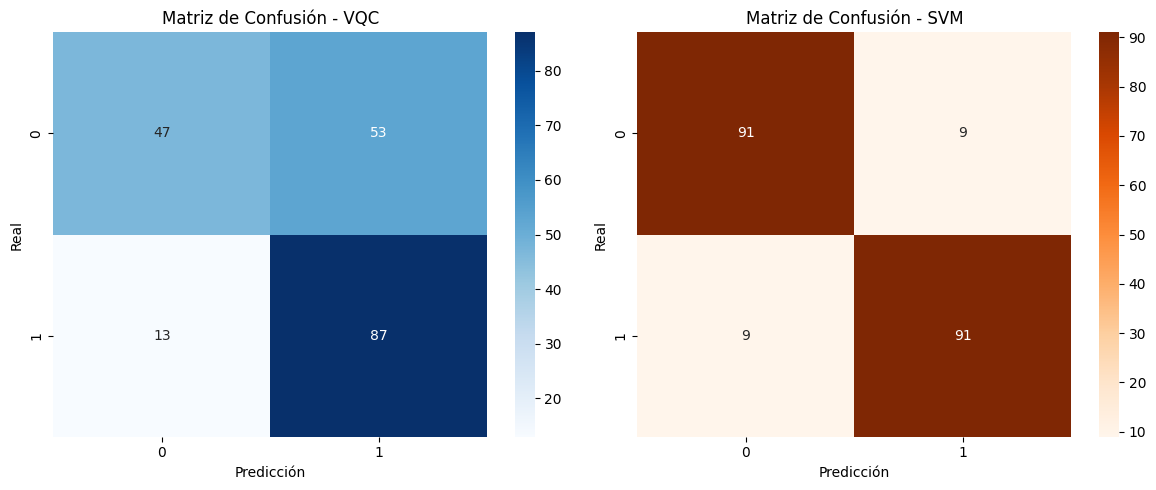

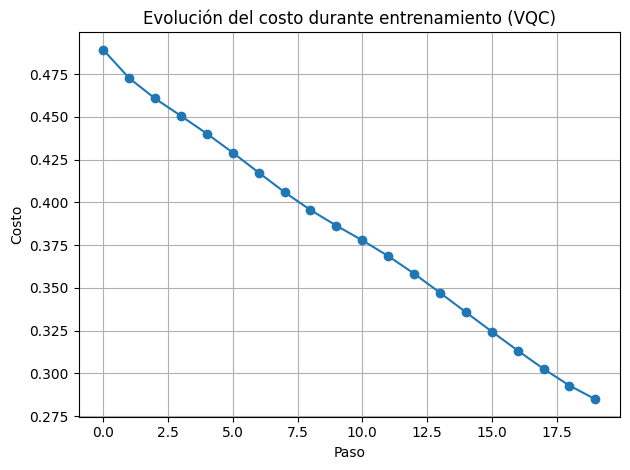



========== COMPARATIVA FINAL ==========

--- VQC ---
              precision    recall  f1-score   support

           0       0.78      0.47      0.59       100
           1       0.62      0.87      0.72       100

    accuracy                           0.67       200
   macro avg       0.70      0.67      0.66       200
weighted avg       0.70      0.67      0.66       200

--- SVM ---
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       100
           1       0.91      0.91      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



In [ ]:

'''
 CLASIFICACIÓN DE GALAXIAS CON VQC/COMPARATIVA CON SVM/ANÁLISIS GRÁFICO
 ---------------------------------------------------------------
 - Se sube el archivo con datos de galaxias preprocesadas.
 - Entrenamiento del clasificador cuántico (VQC) con AngleEmbedding.
 - Entrenamiento del clasificador clásico SVM.
 - Se evalúa ambos modelos con accuracy, f1-score, curva ROC y matriz de confusión.
 - Se muestra que el costo del VQC paso por paso (gráfico de convergencia).
 - Se genera la comparación final.
'''


# Paso 1: se sube el archivo CSV (galaxias_preprocesadas.csv)
from google.colab import files
uploaded = files.upload()

# Paso 2: se carga y se prepara el conjunto de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo)

# Se usan 8 columnas (sin el campo 'concentracion') para poder usar 3 cúbits.
X = df.drop(columns=["etiqueta", "concentracion"])
y = df["etiqueta"]

# Se hace escalado y split
escalador = StandardScaler()
X_escalado = escalador.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_escalado, y, test_size=0.2, random_state=42, stratify=y)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Paso 3: modelo cuántico VQC
##!pip install pennylane --quiet
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer

num_cubits = X_train.shape[1]
num_capas = 3

# Dispositivo y circuito
dev = qml.device("default.cubit", wires=num_cubits)

def circuito_cuantico(x, parametros):
    qml.AngleEmbedding(x, wires=range(num_cubits), rotation='Y')
    qml.StronglyEntanglingLayers(parametros, wires=range(num_cubits))
    return qml.expval(qml.PauliZ(wires=num_cubits - 1))

@qml.qnode(dev)
def qnode(x, parametros):
    return circuito_cuantico(x, parametros)

# Clasificador cuántico
class ClasificadorCuantico:
    def __init__(self, pasos=20, tasa_aprendizaje=0.05):
        self.pasos = pasos
        self.tasa = tasa_aprendizaje
        self.parametros = pnp.random.randn(num_capas, num_cubits, 3, requires_grad=True)
        self.historial_costos = []

    def entrenar(self, X, y):
        opt = AdamOptimizer(self.tasa)
        for paso in range(self.pasos):
            self.parametros = opt.step(lambda p: self._costo(p, X, y), self.parametros)
            costo_actual = self._costo(self.parametros, X, y)
            self.historial_costos.append(costo_actual)
            if paso % 5 == 0 or paso == self.pasos - 1:
                print(f"Paso {paso} - Costo: {costo_actual:.4f}")

    def _costo(self, parametros, X, y):
        predicciones = [qnode(x, parametros) for x in X]
        return pnp.mean((pnp.array(predicciones) - y) ** 2)

    def predecir(self, X):
        return [1 if qnode(x, self.parametros) >= 0 else 0 for x in X]

    def probabilidades(self, X):
        return [float((qnode(x, self.parametros) + 1) / 2) for x in X]  # escala Z (-1,1) a (0,1)

# Paso 4: se entrena el modelo VQC
modelo_vqc = ClasificadorCuantico(pasos=20, tasa_aprendizaje=0.05)
modelo_vqc.entrenar(X_train, y_train)
y_pred_vqc = modelo_vqc.predecir(X_test)
y_score_vqc = modelo_vqc.probabilidades(X_test)

# Paso 5: se entrena el modelo SVM
from sklearn.svm import SVC
modelo_svm = SVC(kernel='rbf', probability=True)
modelo_svm.fit(X_train, y_train)
y_pred_svm = modelo_svm.predict(X_test)
y_score_svm = modelo_svm.predict_proba(X_test)[:, 1]

# Paso 6: obtener métricas y curvas ROC
fpr_vqc, tpr_vqc, _ = roc_curve(y_test, y_score_vqc)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
auc_vqc = auc(fpr_vqc, tpr_vqc)
auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(6, 5))
plt.plot(fpr_vqc, tpr_vqc, label=f'VQC (AUC = {auc_vqc:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Curva ROC - VQC vs SVM")
plt.xlabel("Tasa de falsos positivos")
plt.ylabel("Tasa de verdaderos positivos")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 7: matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_vqc), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Matriz de Confusión - VQC")
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title("Matriz de Confusión - SVM")
for ax in axes:
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
plt.tight_layout()
plt.show()

# Paso 8: Gráfico de convergencia del VQC
plt.plot(range(len(modelo_vqc.historial_costos)), modelo_vqc.historial_costos, marker='o')
plt.title("Evolución del costo durante entrenamiento (VQC)")
plt.xlabel("Paso")
plt.ylabel("Costo")
plt.grid(True)
plt.tight_layout()
plt.show()

# Paso 9: Comparativa final
print("\n\n========== COMPARATIVA FINAL ==========")
print("\n--- VQC ---")
print(classification_report(y_test, y_pred_vqc))
print("--- SVM ---")
print(classification_report(y_test, y_pred_svm))
